- Make learner work generically

- Make it work with add_col=True
- Make it work with n_jobs > 1

In [1]:
#default_exp tabular_api

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#export
from hypster.oo_hp import *
from hypster.hypster_prepare import *

import fastai2
from fastai2.tabular.all import *
from fastai2.metrics import *

from sklearn.model_selection import train_test_split

from copy import deepcopy

import optuna

In [4]:
#export
SEED = 42

# Read Data

In [5]:
#export
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('C:/Users/user/.fastai/data/adult_sample/adult.csv'),Path('C:/Users/user/.fastai/data/adult_sample/export.pkl'),Path('C:/Users/user/.fastai/data/adult_sample/models')]

In [6]:
#export
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [7]:
#export
df = df.sample(frac=0.1)

In [8]:
#export
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
dep_var = "salary"

In [9]:
#export
train_df, test_df = train_test_split(df, test_size=0.6, 
                                     random_state=SEED, 
                                     stratify=df[dep_var])

# Preprocessing

In [10]:
FillMissing = prepare(FillMissing)

In [11]:
fill_strategy = HpCategorical("fill_strategy", 
                              [FillStrategy.mode, 
                               FillStrategy.median, 
                               #FillStrategy.constant(5, fill)
                              ])

In [12]:
#imp = FillMissing(fill_strategy=fill_strategy, add_col=HpBool("add_col"))

In [13]:
imp = FillMissing(fill_strategy=fill_strategy, add_col=False)

In [14]:
#export
Normalize = prepare(Normalize)
norm = Normalize(mean=HpFloat("mean_norm", 0.001, 10.4))

In [15]:
#export
procs = [Categorify, imp, HpToggle("norm_bool", norm)]

# DataBunch

In [16]:
import fastai2

In [17]:
TabularPandas = prepare(fastai2.tabular.data.TabularPandas)

In [18]:
#export
to = TabularPandas(train_df,
                   y_block = CategoryBlock(), 
                   y_names = dep_var,
                   splits = RandomSplitter()(range_of(train_df)),
                   cat_names = cat_names,
                   cont_names = cont_names,
                   procs = procs,
                   reduce_memory=False,
                   inplace=False
                  )

In [19]:
#export
#dls = to.dataloaders(batch_size=2 ** HpInt("batch_size", 5, 9))
#dls = to.dataloaders(batch_size=HpInt("batch_size", 16, 128, 16))

In [20]:
#export
dls = to.dataloaders(batch_size=32)

# Learner

In [21]:
#export
cbs = [TrackerCallback(monitor="roc_auc_score"), 
       ReduceLROnPlateau("roc_auc_score", patience=3)]

In [22]:
#export
start_mom = HpFloat("start_mom", 0.85, 0.99)

In [23]:
#export
tabular_learner = prepare(tabular_learner)

In [24]:
#export
learner = tabular_learner(dls,
                          metrics=RocAuc(),
                          opt_func=HpCategorical("optimizer", [Adam, SGD, QHAdam]),
                          layers=HpVarLenList("layers", 1, 4, HpInt("layer_size", 50, 300, 50), same_value=False),
                          cbs=cbs,
                          moms=(start_mom, start_mom-0.1, start_mom), 
                          wd_bn_bias=HpBool("wd_bn_bias"),
                          )

# Optuna

In [25]:
def log_optuna_param(param_name, result, trial):
    import optuna
    trial.study.storage.set_trial_param(trial.number,
                                        param_name, 
                                        result,
                                        optuna.distributions.LogUniformDistribution)

In [26]:
def set_trial_param(trial_id, param_name, param_value_internal, distribution):
    # type: (int, str, float, distributions.BaseDistribution) -> bool

        trial = self._get_trial(trial_id)

        self.check_trial_is_updatable(trial_id, trial.state)

        study_id = self._trial_id_to_study_id_and_number[trial_id][0]
        # Check param distribution compatibility with previous trial(s).
        if param_name in self._studies[study_id].param_distribution:
            distributions.check_distribution_compatibility(
                self._studies[study_id].param_distribution[param_name], distribution
            )

        # Check param has not been set; otherwise, return False.
        if param_name in trial.params:
            return False

        # Set param distribution.
        self._studies[study_id].param_distribution[param_name] = distribution

        # Set param.
        trial = copy.copy(trial)
        trial.params = copy.copy(trial.params)
        trial.params[param_name] = distribution.to_external_repr(param_value_internal)
        trial.distributions = copy.copy(trial.distributions)
        trial.distributions[param_name] = distribution
        self._set_trial(trial_id, trial)

        return True

In [27]:
lr = HpFloat("learning_rate", 1e-5, 1e-1, log=True)

In [28]:
def lr_finder(trial, learner, **kwargs):
    learner = learner.sample(trial)
    lr_min, lr_steep = learner.lr_find(**kwargs)
    return lr_steep

In [29]:
lr = HpFunc("learning_rate", lr_finder, learner=learner)

In [30]:
import datetime

In [31]:
#export
def run_learner(fit_method, get_metric, n_trials=5): #learner
    class Objective():
        def __init__(self, fit_method, get_metric): #learner
            #self.learner   = learner
            self.fit_method = fit_method
            self.get_metric = get_metric
            
        def __call__(self, trial): 
            #learner = self.learner.sample(trial)
            self.fit_method.sample(trial)
            res = self.get_metric.sample(trial)
            #print(self.fit_method.base_call)
            #print(self.get_metric.base_call.base_call)
            print(res)
            return res

    objective = Objective(fit_method, get_metric) #learner
    optuna.logging.set_verbosity(0)
    pruner = optuna.pruners.NopPruner()
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    study = optuna.create_study(direction="maximize", study_name = now, pruner=pruner)
    study.optimize(objective, n_trials=n_trials, n_jobs=1, timeout=600)
    return study

epoch,train_loss,valid_loss,roc_auc_score,time
0,2.064457,0.828563,0.500000,00:00
1,1.069090,0.579495,0.500000,00:00


0.5


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.471566,0.421068,0.697164,00:00
1,0.402532,0.387384,0.737813,00:00


0.737813230199017


epoch,train_loss,valid_loss,roc_auc_score,time
0,1.162286,0.559821,0.715696,00:00
1,0.712120,0.427939,0.767988,00:00


0.767988075094674


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.456756,0.491638,0.729554,00:00
1,0.381080,0.406497,0.750504,00:00


0.7505035855289662


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.478295,0.490150,0.539683,00:00
1,0.401274,0.412696,0.710821,00:00


0.7108210458464265


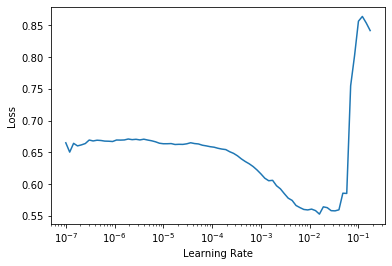

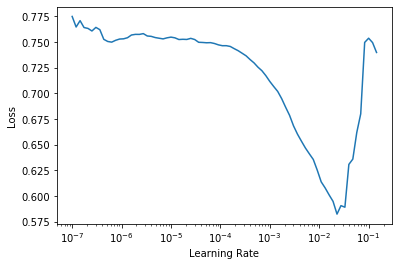

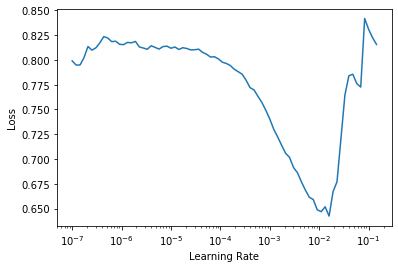

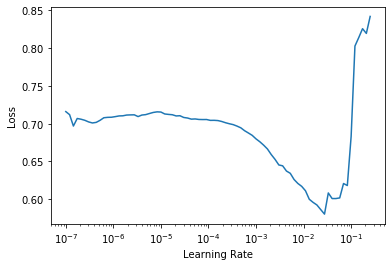

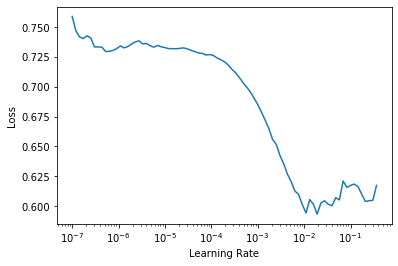

In [32]:
#export
study = run_learner(#learner    = learner,
                    fit_method = learner.fit_one_cycle(2, lr),
                    get_metric = learner.tracker.best,
                    n_trials   = 5
                   )

In [33]:
#export
print("Number of finished trials: {}".format(len(study.trials)))

Number of finished trials: 5


In [34]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

Best trial:
  Value: 0.767988075094674


In [35]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    fill_strategy: median
    norm_bool: False
    optimizer: QHAdam
    layers: 3
    layer_size_1: 300
    layer_size_2: 200
    layer_size_3: 150
    start_mom: 0.909994669209903
    wd_bn_bias: True


In [36]:
#export
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,params_fill_strategy,params_layer_size_1,params_layer_size_2,params_layer_size_3,params_layers,params_mean_norm,params_norm_bool,params_optimizer,params_start_mom,params_wd_bn_bias,user_attrs_learning_rate,state
0,0,0.500000,2020-05-30 16:06:37.110384,2020-05-30 16:06:40.039381,mode,300,150.0,150.0,3,NaN,False,QHAdam,0.862896,True,0.144544,COMPLETE
1,1,0.737813,2020-05-30 16:06:40.040381,2020-05-30 16:06:42.038380,median,300,NaN,NaN,1,3.334980,True,QHAdam,0.948960,True,0.019055,COMPLETE
2,2,0.767988,2020-05-30 16:06:42.039380,2020-05-30 16:06:44.868380,median,300,200.0,150.0,3,NaN,False,QHAdam,0.909995,True,0.083176,COMPLETE
3,3,0.750504,2020-05-30 16:06:44.869380,2020-05-30 16:06:46.879380,mode,50,150.0,NaN,2,9.056469,True,QHAdam,0.967579,True,0.010965,COMPLETE
4,4,0.710821,2020-05-30 16:06:46.880381,2020-05-30 16:06:49.372381,median,300,50.0,300.0,3,NaN,False,Adam,0.931942,False,0.002512,COMPLETE


In [37]:
from nbdev.export import notebook2script

In [38]:
notebook2script()

Converted 00_core.ipynb.
Converted 01_api.ipynb.
Converted 02_oo_hp.ipynb.
Converted 03_hypster_prepare.ipynb.
Converted 04_tabular_api.ipynb.
Converted 05_sklearn.ipynb.
Converted fastai_adult_tutorial.ipynb.
Converted index.ipynb.
